Sample Applet for Taking Assessment Roll and Producing Summary Report of Residential Housing

In [1]:
# Import Packages

import pandas as pd
import numpy as np
# These packages and files below are for data visualization and mapping
#! pip install pyshp
#import shapefile as shp
#import matplotlib.pyplot as plt
#import seaborn as sns

#The code below was used for initial testing from a JSON file
#import requests
#from pandas.io.json import json_normalize

# Get CSV Files for Analysis
asmdata = pd.read_csv("/Users/johnobrien/Downloads/Current__2021-2022__Assessment_Roll.csv")
covidata = pd.read_csv("/Users/johnobrien/Downloads/Code_Violations.csv")
#shp_path = "/Users/johnobrien/Downloads/Neighborhoods/Neighborhoods.shp"
#sf = shp.Reader(shp_path)
# print("Data downloaded!")

/Users/johnobrien/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (82,83) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data downloaded!


/Users/johnobrien/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


After downloading the data file, this column will pull out the relevant rows for the major types of residential housing.

In [18]:
# This code should standardize the data for the basic reporting assuming common metadata can be drawn 
# from the list below
subset_df = asmdata[['PROP CLASS DESCRIPTION',
                     'PROPERTY CLASS CODE',
                     'OWNER1',
                     'MAIL3',
                     'MAIL4',
                     'HOUSE NUMBER',
                     'STREET',
                     'TOTAL VALUE',
                     'LAND VALUE',
                     'COUNCIL DISTRICT',
                     'CENSUS TRACT',
                     'NEIGHBORHOOD']].copy()
covi = covidata[['Case Number',
                 'Date',
                 'Status',
                 'Code',
                 'Description',
                 'Address',
                 'Neighborhood',
                 'Prop Class']].copy()
covi['Description'] = covi['Description'].fillna("_blank_")
covi['Description'] = covi['Description'].astype("str")
covi['Address'] = covi['Address'].fillna("_blank_")
covi['Address'] = covi['Address'].astype("str")

# Fix string types for later analysis
subset_df['PROPERTY CLASS CODE'] = subset_df['PROPERTY CLASS CODE'].fillna('0')
subset_df['PROPERTY CLASS CODE'] = subset_df['PROPERTY CLASS CODE'].astype("int")
subset_df['TOTAL VALUE'] = subset_df['TOTAL VALUE'].fillna('0')
subset_df['TOTAL VALUE'] = subset_df['TOTAL VALUE'].astype("int")
subset_df['MAIL3'] = subset_df['MAIL3'].astype("str")
subset_df['TOTAL VALUE'] = subset_df['TOTAL VALUE'].astype("int")
covi['Description'] = covi['Description'].fillna("_blank_")
covi['Description'] = covi['Description'].astype("str")
covi['Address'] = covi['Address'].fillna("_blank_")
covi['Address'] = covi['Address'].astype("str")
covi['Prop Class'] = covi['Prop Class'].fillna("0")
covi['Prop Class'] = covi['Prop Class'].astype("int")

# Modify the below to the equivalent property class codes in your municipality
single_unit_housing = 210
two_unit_housing = 220
three_unit_housing = 230
mutliple_structure = 281 # In NY, this refers to plots that might contain an Accessory Dwelling Unit
apartment_building = 411
rowhouses = 482

# Identifies and sets aside the main Residential Property Class Codes in both Assessment and CoVi Datasets
residential_housing1 = subset_df.loc[subset_df['PROPERTY CLASS CODE']==single_unit_housing]
residential_housing2 = subset_df.loc[subset_df['PROPERTY CLASS CODE']==two_unit_housing]
residential_housing3 = subset_df.loc[subset_df['PROPERTY CLASS CODE']==three_unit_housing]
residential_housing4 = subset_df.loc[subset_df['PROPERTY CLASS CODE']==mutliple_structure]
residential_housing5 = subset_df.loc[subset_df['PROPERTY CLASS CODE']==apartment_building]
residential_housing6 = subset_df.loc[subset_df['PROPERTY CLASS CODE']==rowhouses]
rht = residential_housing1.append([residential_housing2,
                                  residential_housing3,
                                  residential_housing4,
                                  residential_housing5,
                                  residential_housing6])

# The items below will create additional columns which might be beneficial for analysis
# The next two lines ensure we have complete Address values - initial viewing of PDF showed numerous blanks
rht['ADDRESS'] = rht['HOUSE NUMBER'].astype("str") + " " + rht['STREET']
rht['ADDRESS'] = rht['ADDRESS'].astype("str")

# This block of code will separate the City and State in the Mail4 column, telling us where property owners live
rht['CITY']=''
rht['STATE']=''
rht['CITY'] = rht['MAIL4'].str.split(',',expand=True)[0]
rht['STATE'] = rht['MAIL4'].str.split(',',expand=True)[1]
rht['CITY'] = rht['CITY'].astype("str")
rht['STATE'] = rht['STATE'].astype("str")

# This block of code will help us to identify whether a building is likely owner or renter occupied
rht['LIKELY TENURE']=''
rht.loc[rht['MAIL3'].str[0:6] == rht['ADDRESS'].str[0:6],'LIKELY TENURE'] = 'Likely OO'
rht.loc[rht['MAIL3'].str[0:6] != rht['ADDRESS'].str[0:6],'LIKELY TENURE'] = 'Likely RO'

# This block of code will create a new column that only contains the first few characters of the Mail3
# This will help us to identify likely common property owners despite different LLCs and misspelt addresses
# The analysis enabled here is usually best when limited to just 6 characters

rht['MAIL3_Comparison']=''
rht['MAIL3_Comparison']=rht['MAIL3'].str[0:10]

# This dictionary will help standardize identified errors in the entry of mailing address locations
# Edit and add this, as needed, to fit the assessment roll being used
rht_replacement_dict = {
    "BFLO": "BUFFALO",
    "BUFFAL0": "BUFFALO",
    "BUFFLAO": "BUFFALO",
    "0UFFALO": "BUFFALO",
    "BUUFALO": "BUFFALO",
    "BUFFLO":"BUFFALO",
    "BUFFFALO":"BUFFALO",
    "BUFFALONY":"BUFFALO",
    "BUFFALO N":"BUFFALO",
    "BUFFAL":"BUFFALO",
    "BUFFRALO":"BUFFALO",
    "W SENECA": "WEST SENECA",
    "E AMHERST": "EAST AMHERST",
    "N TONAWANDA": "NORTH TONAWANDA",
    "BUFFALO 14213 ": "BUFFALO",
    "LIONS HEAD ONTARIO N0H1W0": "LIONS HEAD",
    "TONWANDA":"TONAWANDA"
}
rht['CITY'] = rht['CITY'].replace(rht_replacement_dict)

#This block will combine the Residential Housing Assessment Data with the Code Violation Data
covi_rht_merge = pd.merge(covi,rht,left_on='Address',right_on='ADDRESS',how='inner')
covi_rht_merge = covi_rht_merge[['Case Number',
                                'Date',
                                'Status',
                                'Code',
                                'Description',
                                'ADDRESS',
                                'PROP CLASS DESCRIPTION',
                                'PROPERTY CLASS CODE',
                                'OWNER1',
                                'MAIL3',
                                'TOTAL VALUE',
                                'LAND VALUE',
                                'COUNCIL DISTRICT',
                                'CENSUS TRACT',
                                'NEIGHBORHOOD',
                                'CITY',
                                'STATE',
                                'LIKELY TENURE',
                                'MAIL3_Comparison']].copy()

# A status of 'Complied' means the Violation was abated without housing court intervention
# 'Closed' status means the case was sent to housing court, but the cited issue could still exist.
# 'Active' code violations are those that have been opened, but either not checked for compliance or sent to court
# as of yet.
# The below code will group violations at residential properties by the MAIL3 Comparison column values
covi_active = covi_rht_merge.loc[covi_rht_merge['Status'] == 'ACTIVE']
crm = covi_active.pivot_table(index='MAIL3_Comparison',
                                 values='Case Number',
                                 columns='PROPERTY CLASS CODE',
                                 aggfunc='count',
                                 margins=True,
                                 fill_value=0)
crm = crm.sort_values(by='All',ascending=False)

# This block will sort the properties by comparable property addresses - this is complicated by PO Boxes,
# but workarounds do exist. It will produce a list of the largest property 
likelyRO = rht.loc[rht['LIKELY TENURE'] == 'Likely RO']
owneradd = likelyRO.pivot_table(index=['MAIL3_Comparison'],
                     values='ADDRESS',
                     columns='PROPERTY CLASS CODE',
                     aggfunc='count',
                     margins=True,
                     fill_value=0)
owneradd = owneradd.sort_values(by='All',ascending=False)

# Now that we have a merged table that will allow us to aggregate Code Violations by Property Information,
# we can group and aggregate that information to find some of the larger problematic property owners
crm_subset = []
crm_subset = crm.head(51).index.tolist()
crm_subset = np.delete(crm_subset,[0]) # Below line deletes the 'All' row in the pivot table
# These lines will filter the Residential Housing dataset down to only those properties owned by the 50 largest
# property owners of properties with 
rht_crm_subset = rht.loc[rht['MAIL3_Comparison'].isin(crm_subset)]
rht_crm_subset = rht_crm_subset.sort_values(by=['MAIL3'],ascending=False)


# This information can be compared to the CSV produced below, which simply aggregates the largest individual
# residential property owners
most_props_subset = []
most_props_subset = owneradd.head(51).index.tolist()
most_props_subset = np.delete(most_props_subset,[1])
mps = rht.loc[rht['MAIL3_Comparison'].isin(most_props_subset)]
mps = mps.sort_values(by=['MAIL3'],ascending=False)

# The two lines below will export the information to a CSV - you may want to update the folder that information
# will be directed to
rht_crm_subset.to_csv("all_properties_of_largest_violators.csv",index=False,float_format='%.2f')
mps.to_csv("most_properties.csv",index=False,float_format='%.2f')


At this juncture, we should have a relatively complete set of city-wide data ready to analyze and summarize through Pivot Tables.

In [8]:
'''The below content is a collection of pivot tables that were put together for exploratory analysis.'''


'''
# This will produce a pivot table summarizing the towns where individual property owners live (or at the very least,
# where they have their tax bills sent - likely a measure of dwelling or location)

pt = rht.pivot_table(index='CITY',
                     values='ADDRESS',
                     columns='LIKELY TENURE',
                     aggfunc='count',
                     fill_value=0)
pt = pt.sort_values(by=['Likely OO'],ascending=False)
pt.head()

# This block of code will perform a similar analysis as above but include the Property Types in each
pt2 = rht.pivot_table(index='CITY',
                     values='ADDRESS',
                     columns=['LIKELY TENURE','PROPERTY CLASS CODE'],
                     aggfunc='count',
                     margins=True,
                     fill_value=0)
pt2 = pt2.sort_values(by=['All'],ascending=False)
pt2.head()



# This will produce a pivot table identifying the likely tenure of all properties within the City's 
# Planning Neighborhoods and organizes them by the percentage of likely owner-occupied properties.
nt = rht.pivot_table(index='NEIGHBORHOOD',
                     values='ADDRESS',
                     columns='LIKELY TENURE',
                     aggfunc='count',
                     fill_value=0)
nt['% Likely OO'] = nt['Likely OO']/(nt['Likely OO'] + nt['Likely RO'])
nt = nt.sort_values(by='% Likely OO', ascending=False)
nt.head()


# This code will calculate the difference in price between owner-occupied and renter-occupied singles and doubles,
# and what is clear is that in all planning neighborhoods, likely owner-occupied buildings are worth more than their
# likely renter-occupied counterparts.
singdoub = rht.loc[subset_df['PROPERTY CLASS CODE']== 210]
singdoub = singdoub.append(rht.loc[subset_df['PROPERTY CLASS CODE']==220])
nmeanval = singdoub.pivot_table(index='NEIGHBORHOOD',
                                      values='TOTAL VALUE', 
                                      columns='LIKELY TENURE', 
                                      aggfunc='median',
                                      fill_value=0)
nmeanval['% Diff. OO'] = (nmeanval['Likely OO'] - nmeanval['Likely RO']) / nmeanval['Likely OO']
nmeanval = round(nmeanval,2)
nmeanval = nmeanval.sort_values(by='% Diff. OO', ascending=False)
nmeanval.head()

#This set of code will focus solely on Singles and Doubles
owners_singdoub = singdoub.pivot_table(index=['OWNER1','MAIL3_Comparison'],
                     values='ADDRESS',
                     aggfunc='count',
                     fill_value=0)
owners_singdoub = owners_singdoub.sort_values(by='ADDRESS',ascending=False)
owners_singdoub.head()



'''

"\n# This will produce a pivot table summarizing the towns where individual property owners live (or at the very least,\n# where they have their tax bills sent - likely a measure of dwelling or location)\n\npt = rht.pivot_table(index='CITY',\n                     values='ADDRESS',\n                     columns='LIKELY TENURE',\n                     aggfunc='count',\n                     fill_value=0)\npt = pt.sort_values(by=['Likely OO'],ascending=False)\npt.head()\n\n# This block of code will perform a similar analysis as above but include the Property Types in each\npt2 = rht.pivot_table(index='CITY',\n                     values='ADDRESS',\n                     columns=['LIKELY TENURE','PROPERTY CLASS CODE'],\n                     aggfunc='count',\n                     margins=True,\n                     fill_value=0)\npt2 = pt2.sort_values(by=['All'],ascending=False)\npt2.head()\n\n\n\n# This will produce a pivot table identifying the likely tenure of all properties within the City

In [10]:
testprint = rht.loc[rht['MAIL3_Comparison']=='']
tp_table = testprint.pivot_table(index=['OWNER1'],
                     values='ADDRESS',
                     columns=['NEIGHBORHOOD','PROPERTY CLASS CODE'],
                     aggfunc='count',
                     margins=True,
                     fill_value=0)
tp_table = tp_table.sort_values(by=['All'],ascending=False)
tp_table

NEIGHBORHOOD              Elmwood Bidwell     Elmwood Bryant North Park      \
PROPERTY CLASS CODE                   230 411            411        210 411   
OWNER1                                                                        
All                                     1   2              3          1   3   
NATALIA PROPERTIES LLC                  1   2              3          0   0   
GRECO PROPERTIES LLC                    0   0              0          0   3   
AGRO GAETANO C & DANIELLE               0   0              0          1   0   

NEIGHBORHOOD              Parkside All  
PROPERTY CLASS CODE            411      
OWNER1                                  
All                              2  12  
NATALIA PROPERTIES LLC           0   6  
GRECO PROPERTIES LLC             2   5  
AGRO GAETANO C & DANIELLE        0   1

In [11]:
len(sf.shapes())

35

In [15]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        
def plot_map2(id, sf, x_lim = None, y_lim = None, figsize=(11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat, 'b', linewidth=3) 
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

def calc_color(data, color=None):
    if color   == 1: 
        color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0','#807dbaF0','#6a51a3F0','#54278fF0']; 
        colors = 'Purples';
    elif color == 2: 
        color_sq = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494']; 
        colors = 'YlGnBu';
    elif color == 3: 
        color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd','#969696','#636363','#252525']; 
        colors = 'Greys';
    elif color == 9: 
        color_sq = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']
    else:            
        color_sq = ['#ffffd4','#fee391','#fec44f','#fe9929','#d95f0e','#993404']; 
        colors = 'YlOrBr';
    
    new_data, bins = pd.qcut(data,6,retbins=True,labels=list(range(6)))
    color_ton = []
    for val in new_data:
        color_ton.append(color_sq[val]) 
    if color != 9:
        colors = sns.color_palette(colors, n_colors=6)
        sns.palplot(colors, 0.6);
        for i in range(6):
            print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                   " => "+str(int(bins[i+1])-1), end =" ")
        print("\n\n   1   2   3   4   5   6")    
    return color_ton, bins

def plot_map_fill(id, sf, x_lim = None, y_lim = None, figsize = (11,9), color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)    
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.fill(x_lon,y_lat, color)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

def plot_map_fill_multiples_ids(title, nbhd, sf, x_lim = None, y_lim = None, figsize = (11,9), color = 'r'):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
            
    for id in nbhd:
        shape_ex = sf.shape(id)
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        ax.fill(x_lon,y_lat, color)
      # The three lines below will add the number id from the Shapefile to the neighborhood      
      #  x0 = np.mean(x_lon)
      #  y0 = np.mean(y_lat)
      #  plt.text(x0, y0, id, fontsize=10)
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

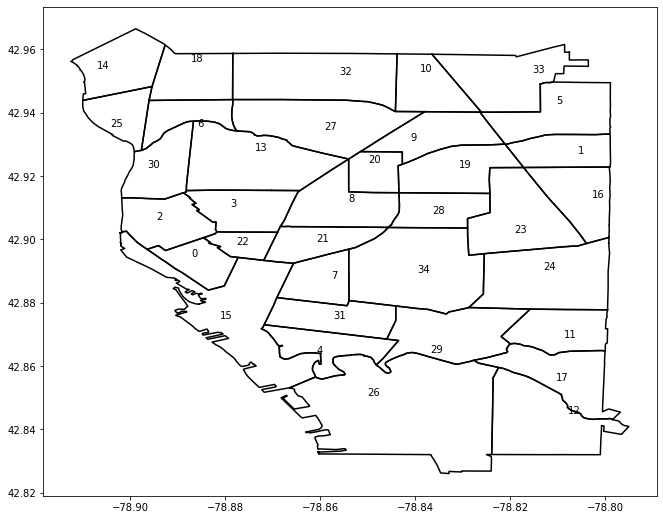

In [14]:
plot_map(sf)